In [1]:
from roarena.corruption import CorruptionJob, CORRUPTIONS
import numpy as np
import torch

c_job = CorruptionJob('store/c-tests', 'datasets', read_only=True)

model_paths = {
    1.5: 'store/exported/BlurResNet50_[1.5].pt',
    2: 'store/exported/BlurResNet50_[2].pt',
    3: 'store/exported/BlurResNet50_[3].pt',
    5: 'store/exported/BlurResNet50_[5].pt',
    9: 'store/exported/BlurResNet50_[9].pt',
    15: 'store/exported/BlurResNet50_[15].pt',
}

accs = {}
for tag, model_path in model_paths.items():
    accs[tag] = []
    for corruption in CORRUPTIONS:
        for severity in range(1, 6):
            config = {'model_path': model_path, 'corruption': corruption, 'severity': severity}
            key = c_job.configs.get_key(config)
            accs[tag].append(c_job.previews[key]['acc'])
    accs[tag] = np.mean(accs[tag])
accs

{1.5: 0.4145706666666667,
 2: 0.4219304,
 3: 0.4205085333333333,
 5: 0.4208288,
 9: 0.40139600000000003,
 15: 0.34190719999999997}

In [2]:
from roarena.einmon import EinMonJob

e_job = EinMonJob('store/e-tests', 'datasets', read_only=True)

alphas = {}
accs_low, accs_high = {}, {}
for tag, model_path in model_paths.items():
    alphas[tag] = set()
    for key in e_job.completed(cond={'model_path': model_path}):
        alphas[tag].add(e_job.configs[key]['alpha'])
    alphas[tag] = sorted(list(alphas[tag]))
    
    accs_low[tag], accs_high[tag] = [], []
    for alpha in alphas[tag]:
        _accs_low, _accs_high = [], []
        for key in e_job.completed(cond={'model_path': model_path, 'alpha': alpha}):
            ckpt = e_job.ckpts[key]
            _accs_low.append(ckpt['acc_low'])
            _accs_high.append(ckpt['acc_high'])
        accs_low[tag].append(_accs_low)
        accs_high[tag].append(_accs_high)
    accs_low[tag] = np.mean(accs_low[tag], axis=1)
    accs_high[tag] = np.mean(accs_high[tag], axis=1)
    
torch.save({
    'alphas': alphas, 'accs_low': accs_low, 'accs_high': accs_high, 'accs': accs,
}, f'store/figs-data/ImageNet-blur_einmon_accs.pt')

In [20]:
from jarvis.vision import prepare_datasets
from roarena.attack import AttackJob

dataset = prepare_datasets('ImageNet', 'datasets')
imgs = []
for i in range(1000):
    img, _ = dataset[i]
    imgs.append(img.numpy())
imgs = np.stack(imgs)

a_job = AttackJob('store/a-tests', 'datasets', read_only=True)

In [5]:
model_path = 'store/exported/BlurResNet50_[3].pt'
dists, advs = [], []
for s_idx in range(1000):
    if (s_idx+1)%20==0:
        print('s_idx: {:3d}'.format(s_idx))
    _min_dists, _, _advs = a_job.best_attack(model_path, 'LI', True, 'elm', 0, sample_idx=s_idx, min_probs=[0.5], return_advs=True)
    dists.append(_min_dists[0])
    advs.append(_advs[0])
dists = np.array(dists)
advs = np.stack(advs)

s_idx:  19
s_idx:  39
s_idx:  59
s_idx:  79
s_idx:  99
s_idx: 119
s_idx: 139
s_idx: 159
s_idx: 179
s_idx: 199
s_idx: 219
s_idx: 239
s_idx: 259
s_idx: 279
s_idx: 299
s_idx: 319
s_idx: 339
s_idx: 359
s_idx: 379
s_idx: 399
s_idx: 419
s_idx: 439
s_idx: 459
s_idx: 479
s_idx: 499
s_idx: 519
s_idx: 539
s_idx: 559
s_idx: 579
s_idx: 599
s_idx: 619
s_idx: 639
s_idx: 659
s_idx: 679
s_idx: 699
s_idx: 719
s_idx: 739
s_idx: 759
s_idx: 779
s_idx: 799
s_idx: 819
s_idx: 839
s_idx: 859
s_idx: 879
s_idx: 899
s_idx: 919
s_idx: 939
s_idx: 959
s_idx: 979
s_idx: 999


In [8]:
from numpy.fft import fft2, fftshift, fftfreq

diffs = imgs-advs
diffs -= diffs.mean(axis=(2, 3), keepdims=True)
powers = np.abs(fft2(diffs))**2
powers[..., 0, 0] = np.nan

logps = fftshift(np.log(powers.mean(axis=(0, 1))))

In [14]:
torch.save(
    {'logps': logps, 'dists': dists},
    'store/figs-data/ImageNet-blur3_advs.pt',
)

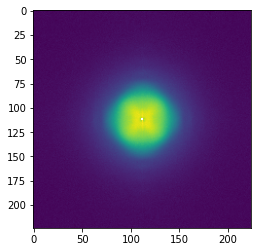

In [10]:
import matplotlib.pyplot as plt

plt.imshow(logps)
plt.show()

In [7]:
imgs.shape

(1000, 3, 224, 224)

In [8]:
model_paths

{1.5: 'store/exported/BlurResNet50_[1.5].pt',
 2: 'store/exported/BlurResNet50_[2].pt',
 3: 'store/exported/BlurResNet50_[3].pt',
 5: 'store/exported/BlurResNet50_[5].pt',
 9: 'store/exported/BlurResNet50_[9].pt',
 15: 'store/exported/BlurResNet50_[15].pt'}

In [23]:
cond = {
    'model_path': 'store/exported/BlurResNet50_[1.5].pt',
    'metric': 'LI', 'targeted': True,
    'shuffle_tag': 0,
}
s_idxs_1 = set()
for key in a_job.completed(cond=cond):
    s_idxs_1.add(a_job.configs[key]['sample_idx'])

In [24]:
len(s_idxs_1)

887

In [26]:
s_idxs = sorted(list(s_idxs_0&s_idxs_1))

In [27]:
imgs.shape

(1000, 3, 224, 224)

In [29]:
import time

dists, advs = {}, {}
for tag, model_path in model_paths.items():
    print(f"Collecting advs for {model_path}...")
    tic = time.time()
    dists[tag] = []
    advs[tag] = []
    for sample_idx in s_idxs:
        _min_dists, _, _advs = a_job.best_attack(model_path, 'LI', True, 'elm', 0, sample_idx=sample_idx, min_probs=[0.5], return_advs=True)
        dists[tag].append(_min_dists[0])
        advs[tag].append(_advs[0])
    dists[tag] = np.array(dists[tag])
    advs[tag] = np.stack(advs[tag])
    toc = time.time()
    print("{:.1f} secs".format(toc-tic))

2581.7 secs
2576.3 secs


In [30]:
imgs.shape

(1000, 3, 224, 224)

In [31]:
imgs = imgs[s_idxs]

In [32]:
torch.save({
    'imgs': imgs,
    'dists': dists,
    'advs': advs,
}, 'store/figs-data/ImageNet-blur-2_advs.pt')

In [32]:
a_job.configs['89CCCB68']

{'model_path': 'store/exported/BlurResNet50_[3].pt',
 'metric': 'LI',
 'targeted': True,
 'shuffle_mode': 'elm',
 'shuffle_tag': 1,
 'sample_idx': 1}

In [6]:
img.max()

tensor(0.9373)

In [36]:
from roarena.attack import AttackJob

a_job = AttackJob('store/a-tests', 'datasets', read_only=True)
# dists = {}
# for tag, model_path in model_paths.items():
#     min_dists, _, advs = a_job.best_attack(model_path, 'LI', True, 'elm', 1, 0, min_probs=[0.1, 0.3, 0.5, 0.7, 0.9])


cond = {
    'model_path': 'store/exported/BlurResNet50_[3].pt',
    'metric': 'LI', 'targeted': True,
    'shuffle_tag': 0,
}
keys = list(a_job.completed(cond=cond))
    

In [37]:
sample_idxs = set()
for key in keys:
    sample_idxs.add(a_job.configs[key]['sample_idx'])

In [38]:
len(sample_idxs)

1000

In [4]:
a_job??

Type:           AttackJob
String form:    <roarena.attack.AttackJob object at 0x7f91ad494130>
File:           /robust-arena/roarena/attack.py
Source:        
class AttackJob(BaseJob):
    r"""Performs adversarial attacks."""

    def __init__(self,
        store_dir, datasets_dir, device=DEVICE,
        **kwargs,
    ):
        super(AttackJob, self).__init__(store_dir=store_dir, **kwargs)
        self.datasets_dir = datasets_dir
        self.device = device if torch.cuda.is_available() else 'cpu'

    def strs2config(self, arg_strs):
        parser = argparse.ArgumentParser()

        parser.add_argument('--model-path', help="path to the model")
        parser.add_argument('--metric', default='LI', choices=METRICS,
                            help="perturbation metric")
        parser.add_argument('--targeted', action='store_true',
                            help="whether the attack is targeted")
        parser.add_argument('--shuffle-mode', default='elm', choices=['elm', 'cls'],
   

In [5]:
next(iter(a_job.configs.values()))

{'model_path': 'store/exported/BlurResNet50_[3].pt',
 'metric': 'L2',
 'targeted': True,
 'shuffle_mode': 'elm',
 'shuffle_tag': 0,
 'sample_idx': 972}

In [20]:
model_path = 'store/exported/BlurResNet50_[3].pt'

min_dists, max_probs, advs = a_job.best_attack(model_path, 'LI', True, 'elm', 1, 0, min_probs=[0.1, 0.3, 0.5, 0.7, 0.9])

In [21]:
np.array(min_dists)*255

array([0.46862125, 0.97956467, 1.1996489 , 1.2750064 , 1.2750064 ],
      dtype=float32)

In [15]:
model_path = 'store/exported/BlurResNet50_[3].pt'

min_dists, max_probs, advs = a_job.best_attack(model_path, 'LI', True, 'elm', 1, 0, min_probs=[0.5], return_advs=True)

In [16]:
min_dists

[0.004704505]

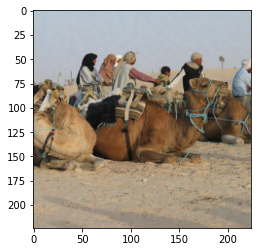

In [17]:
import matplotlib.pyplot as plt
plt.imshow(advs[0].transpose(1, 2, 0))
plt.show()

In [18]:
diffs = advs[0]-img.numpy()

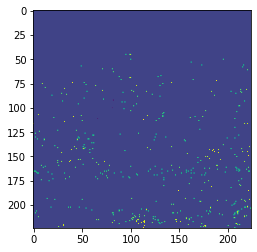

In [19]:
import numpy as np

plt.imshow(np.abs(diffs).max(axis=0))
plt.show()

In [10]:
min_dists

[0.01000002]

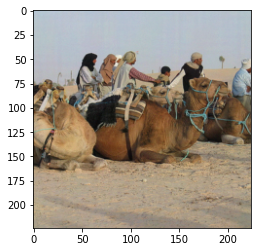

In [11]:
import matplotlib.pyplot as plt
plt.imshow(advs[0].transpose(1, 2, 0))
plt.show()

In [12]:
diffs = advs[0]-img.numpy()

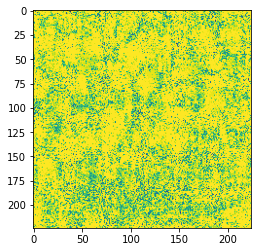

In [14]:
import numpy as np

plt.imshow(np.abs(diffs).max(axis=0))
plt.show()

In [27]:
np.array(min_dists)*255

array([0.9194975, 2.5500052, 2.5500052, 2.5500052, 2.5500052],
      dtype=float32)

In [28]:
model_path = 'store/exported/ResNet50.pt'

min_dists, max_probs, advs = a_job.best_attack(model_path, 'LI', True, 'elm', 1, 0, min_probs=[0.1, 0.3, 0.5, 0.7, 0.9])

In [29]:
np.array(min_dists)*255

array([0.34751415, 0.44089794, 0.44089794, 1.2750064 , 1.2750064 ],
      dtype=float32)